In [3]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(DEVICE)

cuda


Using device: cuda
Epoch 1: Train=67.93% | Val=71.13% | Test=70.83% || TL=0.822 VL=0.758 TeL=0.765
Epoch 2: Train=74.78% | Val=75.90% | Test=75.39% || TL=0.714 VL=0.698 TeL=0.696
Epoch 3: Train=76.82% | Val=76.16% | Test=76.89% || TL=0.677 VL=0.693 TeL=0.680
Epoch 4: Train=78.63% | Val=77.81% | Test=75.91% || TL=0.653 VL=0.677 TeL=0.691
Epoch 5: Train=80.59% | Val=75.90% | Test=77.15% || TL=0.629 VL=0.702 TeL=0.669
Epoch 6: Train=81.35% | Val=77.60% | Test=77.27% || TL=0.613 VL=0.671 TeL=0.679
Epoch 7: Train=83.02% | Val=76.81% | Test=78.11% || TL=0.588 VL=0.681 TeL=0.666
Epoch 8: Train=84.58% | Val=77.45% | Test=77.76% || TL=0.568 VL=0.686 TeL=0.684
Epoch 9: Train=85.56% | Val=78.89% | Test=77.88% || TL=0.554 VL=0.676 TeL=0.687
Epoch 10: Train=86.96% | Val=76.84% | Test=77.46% || TL=0.530 VL=0.707 TeL=0.703
Epoch 11: Train=88.40% | Val=77.90% | Test=79.20% || TL=0.507 VL=0.694 TeL=0.675
Early stopping triggered
Best model saved: /home/student/Downloads/copycat_fer_project/target_resne

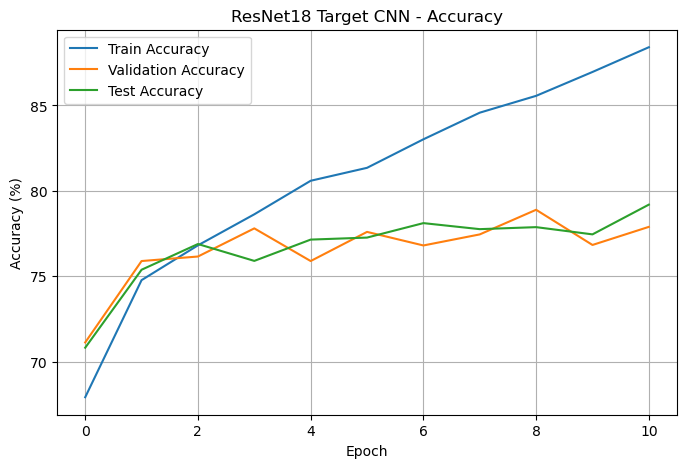

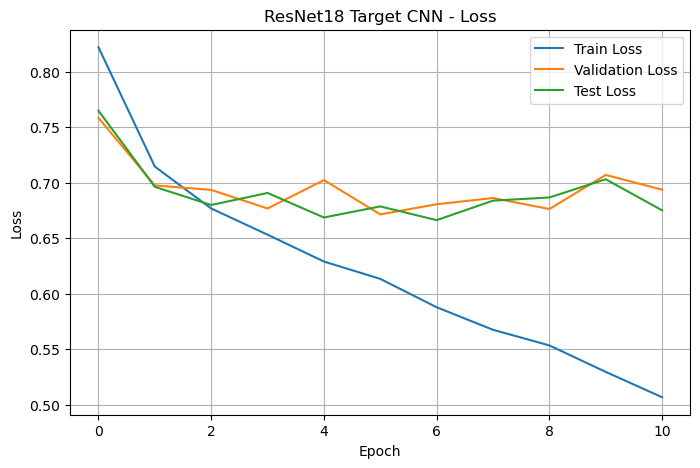

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


# PATHS

TRAIN_DIR = "/home/student/Downloads/copycat_fer_project/FER2013_3 Class/train"
TEST_DIR  = "/home/student/Downloads/copycat_fer_project/FER2013_3 Class/test"
SAVE_PATH = "/home/student/Downloads/copycat_fer_project/target_resnet18_3class.pth"


# CONFIG

BATCH_SIZE = 64
EPOCHS = 25
LR = 5e-4                    
NUM_CLASSES = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)


# TRANSFORMS (STRONGER REGULARIZATION)

train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# DATASETS

full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tf)

val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


# MODEL

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model = model.to(DEVICE)


# PARTIAL FREEZE

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# LOSS + OPTIMIZER
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=1e-4
)

# LR SCHEDULER 
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)

# METRICS
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

best_val_loss = float("inf")
patience = 5
counter = 0


# TRAIN LOOP
for epoch in range(EPOCHS):

    model.train()
    correct, total, running_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    ta = 100 * correct / total
    tl = running_loss / len(train_loader)

    # VALIDATION 
    model.eval()
    vc, vt, vloss = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vloss += loss.item()
            pred = out.argmax(1)
            vc += (pred == y).sum().item()
            vt += y.size(0)

    va = 100 * vc / vt
    vloss /= len(val_loader)

    #  TEST 
    tc, tt, tloss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            tloss += loss.item()
            pred = out.argmax(1)
            tc += (pred == y).sum().item()
            tt += y.size(0)

    te = 100 * tc / tt
    tloss /= len(test_loader)

    scheduler.step()

    train_acc.append(ta)
    val_acc.append(va)
    test_acc.append(te)
    train_loss.append(tl)
    val_loss.append(vloss)
    test_loss.append(tloss)

    print(
        f"Epoch {epoch+1}: "
        f"Train={ta:.2f}% | Val={va:.2f}% | Test={te:.2f}% || "
        f"TL={tl:.3f} VL={vloss:.3f} TeL={tloss:.3f}"
    )

    # EARLY STOPPING
    if vloss < best_val_loss:
        best_val_loss = vloss
        counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

print("Best model saved:", SAVE_PATH)


# ACCURACY GRAPH

plt.figure(figsize=(8,5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ResNet18 Target CNN - Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# LOSS GRAPH
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 Target CNN - Loss")
plt.legend()
plt.grid(True)
plt.show()

